In [3]:
import os
import pandas as pd
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset
from collections import defaultdict
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms



class MIT_states(Dataset):
    directory = 'release_dataset'
    url = 'http://wednesday.csail.mit.edu/joseph_result/state_and_transformation/release_dataset.zip'

    def __init__(self, root, args, train=True, loader=default_loader, download=False, transformation = True):
        self.root = os.path.expanduser(root)
        self.train = train
        self.num_attributes = 312
        self.loader = loader


        nouns = defaultdict(list)
        adjectives = defaultdict(list)
        concat = defaultdict(list)
        images = os.listdir(os.path.join(self.root, self.directory, 'images'))
        all_items = []
        for i, val in enumerate(images):
            if val in ['.DS_Store', '._.DS_Store'] or val[0] == '.': continue
            old_val = val
            val = val.split()
            
            if val[0] not in adjectives:
                adjectives[val[0]] = len(adjectives.keys())
            if val[1] not in nouns:
                nouns[val[1]] = len(nouns.keys())
            if old_val not in concat:
                concat[old_val] = len(concat.keys())

            items = os.listdir(os.path.join(self.root, self.directory, 'images', old_val))
            for item in items:
                if item[0] == '.': continue
                labels = {}
                labels['adjective'] = adjectives[val[0]]
                labels['noun'] = nouns[val[1]]
                labels['concat'] = concat[old_val]
                all_items.append([os.path.join(self.root, self.directory, 'images', old_val, item), labels])

        self.all_items = all_items
        self.adjectives = dict([(value, key) for key, value in adjectives.items()])
        self.nouns = dict([(value, key) for key, value in nouns.items()])
        self.concat = dict([(value, key) for key, value in concat.items()])
        self.transformation = transformation

        self.initial_transforms = transforms.Compose([
                                    transforms.RandomResizedCrop((args['crop_size'], args['crop_size']), scale=(args['min_scale'], args['max_scale']),
                                            interpolation=transforms.InterpolationMode.BICUBIC),
                                    torchvision.transforms.ToTensor()])

        self.transform = torchvision.transforms.Compose([
                            transforms.RandomApply(
                                    [transforms.ColorJitter(args['brightness'], args['contrast'], args['saturation'], args['hue'])],
                                    p=args['color_jitter_prob'],
                                ),
                            torchvision.transforms.RandomHorizontalFlip(p=args['horizontal_flip_prob']),
                            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                std=[0.229, 0.224, 0.225])
                            ])  
        number_items = [i for i in range(len(self.all_items))]
        np.random.seed(0)
        np.random.shuffle(number_items)
        split = int(len(self.all_items) * .8)
        if self.train:
            self.all_items = [self.all_items[i] for i in number_items[:split]]
        else:
            self.all_items = [self.all_items[i] for i in number_items[split:]]

        print('Transforming in training loop', self.transformation)


    def __len__(self):
        return len(self.all_items)

    def __getitem__(self, idx):
        image_path, label = self.all_items[idx]
        img = self.loader(image_path)
        img = self.initial_transforms(img)
        img = torch.clamp(img, 0, 1)
        batch = {}
        batch['unperturbed_image'] = img
        if self.transformation:
            img = self.transform(img)

        
        batch['image'] = img
        batch['image_path'] = image_path
        
        batch['concat_labels'] = label['concat']
        batch['adjective_labels'] = label['adjective']
        batch['noun_labels'] = label['noun']
        batch['idx'] = idx

        return batch


import matplotlib.pyplot as plt
import torchvision.transforms as transforms
dataset_args = {
                'crop_size': 224,
                'brightness': 0.4, 
                'contrast': 0.4, 
                'saturation': .2, 
                'hue': .1, 
                'color_jitter_prob': .4, 
                'gray_scale_prob': 0.2, 
                'horizontal_flip_prob': 0.5, 
                'gaussian_prob': .5, 
                'min_scale': 0.6, 
                'max_scale': 0.95}


dataset = MIT_states(root='../../data/', args = dataset_args, train=True, download=True, transformation = False)

'''#import dataloader
from torch.utils.data import DataLoader
loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)
adjective_idx = 18
noun_idx = 76
photos = []
for data in loader:
    truth = (data['adjective_labels'] == adjective_idx) & (data['noun_labels'] == noun_idx)
    if torch.sum(truth) > 0:
        photos.append(data['idx'][truth])
    if len(photos) > 20: break'''


Transforming in training loop False


../../data/release_dataset/images/coiled cord/302-015BK_new.jpg


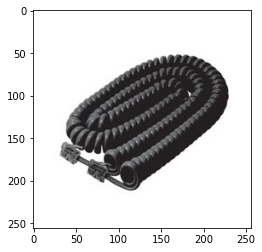

In [18]:
import os
import numpy as np
from PIL import Image
photos = os.listdir('../../data/release_dataset/images/coiled cord')
choice = np.random.choice(photos, 1)[0]
print(os.path.join('../../data/release_dataset/images/coiled cord', choice))
im = Image.open(os.path.join('../../data/release_dataset/images/coiled cord', choice))
plt.imshow(im)

In [19]:
import shutil
shutil.copy('../../data/release_dataset/images/coiled cord/302-015BK_new.jpg', 'inversion/coiled_cord/coiled_cord4.jpg')

'inversion/coiled_cord/coiled_cord4.jpg'